In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from collections import Counter
from typing import List
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

# EDA

In [2]:
df = pd.read_csv('data/transformed_wiki_data.csv', header=0)
df.head()

,id,title,text,generated
0,63064638,Sexhow railway station,Sexhow railway station was a railway station b...,0
1,18704707,Sexhow railway station,Sexhow railway station was a railway station l...,1
2,279621,Etiäinen,"In Finnish folklore, all places and things, an...",0
3,58254742,Etiäinen,"In Finnish folklore, all places and things, an...",1
4,287229,Inverse function theorem,"In mathematics, specifically differential calc...",0


In [3]:
df.shape

(300000, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         300000 non-null  int64 
 1   title      300000 non-null  object
 2   text       300000 non-null  object
 3   generated  300000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 9.2+ MB


In [5]:
df.isna().sum()

id           0
title        0
text         0
generated    0
dtype: int64

In [6]:
df['title'].nunique()

150000

Let's take a look at the number of characters in each text.

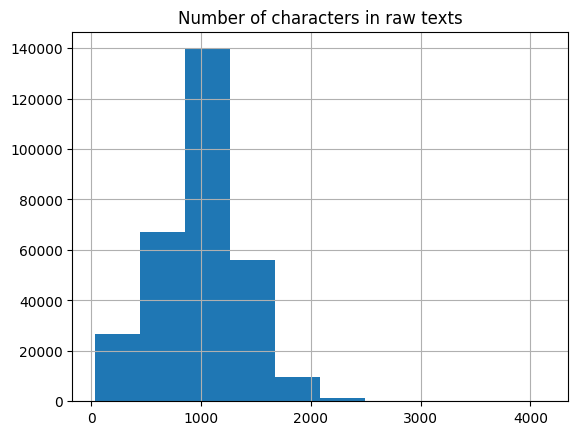

In [10]:
df['text'].str.len().hist()
plt.title('Number of characters in raw texts')
plt.show()

Let's take a look at the number of tokens in each text.

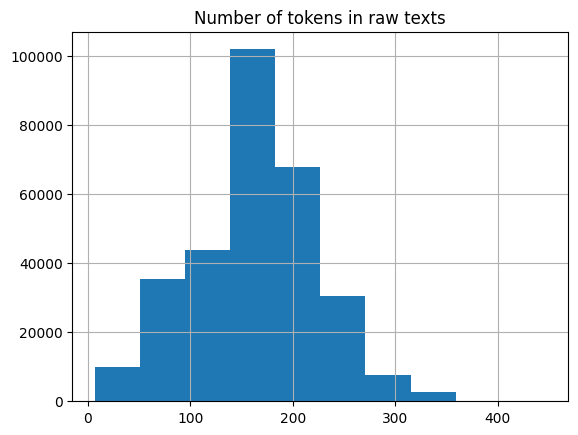

In [11]:
df['text'].str.split().str.len().hist()
plt.title('Number of tokens in raw texts')
plt.show()

Let's take a look at the average word length per text.

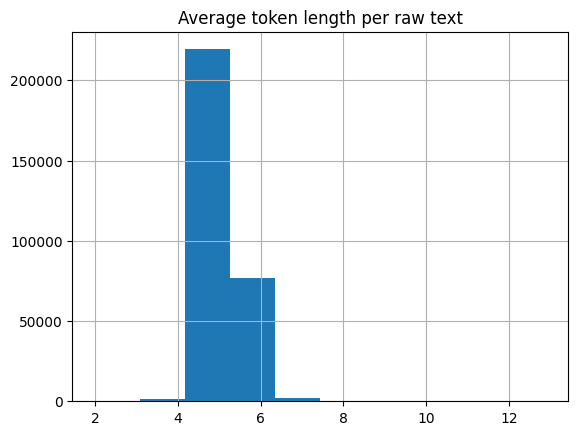

In [13]:
df['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()
plt.title('Average token length per raw text')
plt.show()

In [15]:
stop_words = set(nltk.corpus.stopwords.words('english'))

In [17]:
raw_corpus = []
raw_texts_by_words = [text.split() for text in df['text'].tolist()]
raw_corpus = [word.lower() for text in raw_texts_by_words for word in text]

print(len(raw_corpus), raw_corpus[0])

48981862 sexhow


In [18]:
stopw_cnt = dict.fromkeys(stop_words, 0)
for word in raw_corpus:
    word = word.lower().strip()
    if word in stop_words:
        stopw_cnt[word] += 1

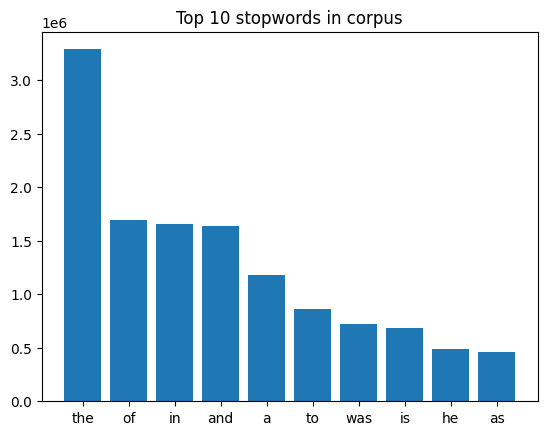

In [19]:
stopw_sorted = sorted(stopw_cnt, key=stopw_cnt.get, reverse=True)
stopw_sorted_vals = [stopw_cnt[word] for word in stopw_sorted]
plt.bar(stopw_sorted[:10], stopw_sorted_vals[:10])
plt.title('Top 10 stopwords in raw corpus')
plt.show()

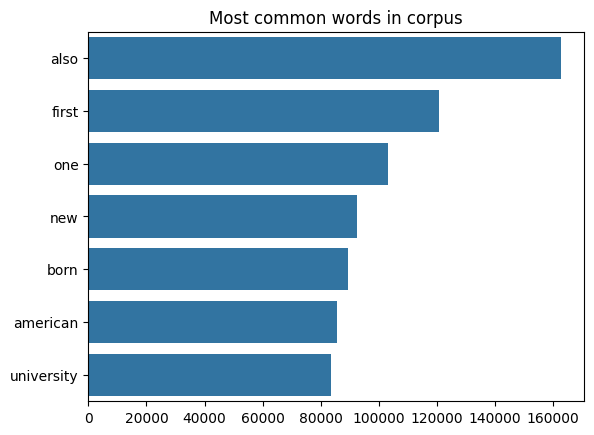

In [21]:
counter = Counter(raw_corpus)
most = counter.most_common()

x, y= [], []
for word, count in most[:40]:
    if (word not in stop_words):
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)
plt.title('Most common words in corpus')
plt.show()

Let's analyze ngrams.

In [24]:
def get_ngrams(corpus: List[str], ngram_from=2, ngram_to=2, n=None):
    
    vec = CountVectorizer(ngram_range = (ngram_from, ngram_to)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0) 
    words_freq = [(word, sum_words[0, i]) for word, i in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
   
    return words_freq[:n]

In [25]:
raw_bigrams = get_ngrams(raw_corpus, ngram_from=2, ngram_to=2, n=10)

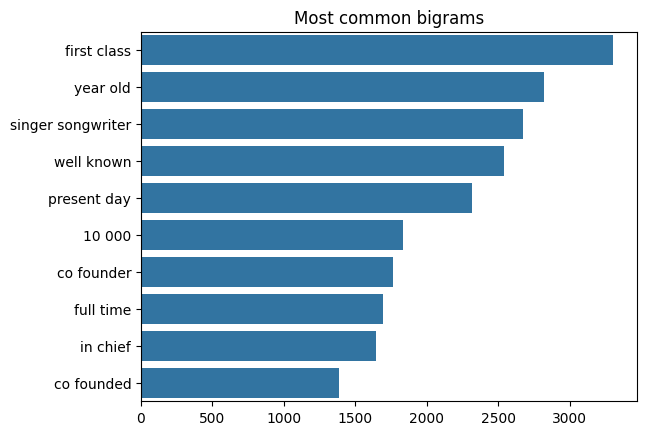

In [26]:
ngrams = [b[0] for b in raw_bigrams]
ngrams_cnt = [b[1] for b in raw_bigrams]
sns.barplot(x=ngrams_cnt, y=ngrams)
plt.title('Most common bigrams')
plt.show()

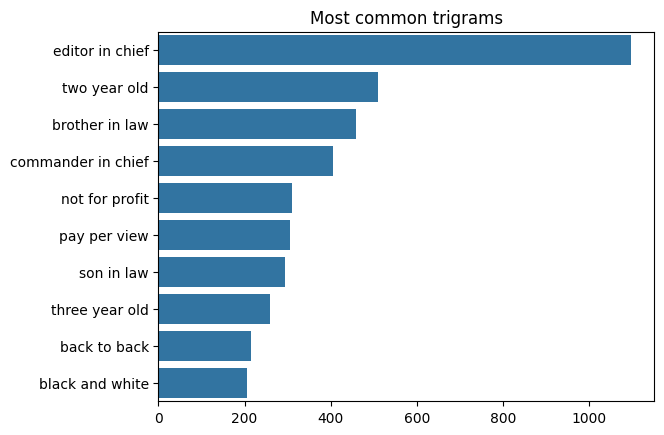

In [27]:
raw_trigrams = get_ngrams(raw_corpus, ngram_from=3, ngram_to=3, n=10)

ngrams = [b[0] for b in raw_trigrams]
ngrams_cnt = [b[1] for b in raw_trigrams]
sns.barplot(x=ngrams_cnt, y=ngrams)
plt.title('Most common trigrams')
plt.show()

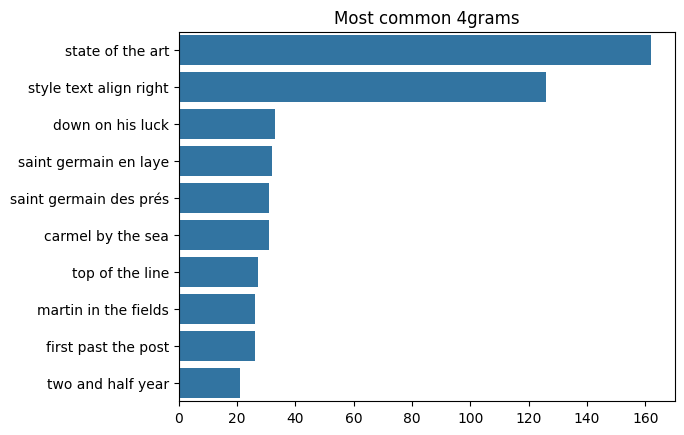

In [28]:
raw_4grams = get_ngrams(raw_corpus, ngram_from=4, ngram_to=4, n=10)

ngrams = [b[0] for b in raw_4grams]
ngrams_cnt = [b[1] for b in raw_4grams]
sns.barplot(x=ngrams_cnt, y=ngrams)
plt.title('Most common 4grams')
plt.show()

## Wordcloud

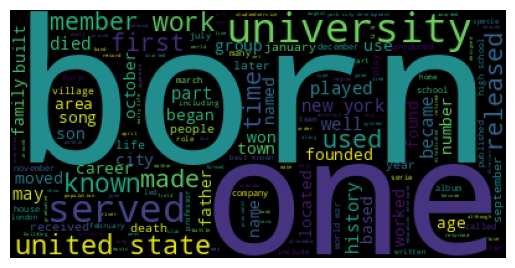

In [31]:
wordcloud = WordCloud().generate(" ".join(raw_corpus))

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()